# wordslab-images - Install prerequisites

In [1]:
from importlib.metadata import version

## Install Huggingface transformers and diffusers

In [ ]:
pip install accelerate

In [3]:
version('accelerate')

'1.2.1'

In [ ]:
pip install --upgrade transformers sentencepiece protobuf

In [5]:
version('transformers')

'4.47.0'

In [ ]:
pip install --upgrade diffusers

In [7]:
version('diffusers')

'0.31.0'

## Install Pytorch native quantization library torchao

Here is a repository explaining how to use torchao with the diffusers library:

https://github.com/sayakpaul/diffusers-torchao

https://github.com/sayakpaul/diffusers-torchao/blob/main/inference/serialization_and_loading.md

In [ ]:
pip install --upgrade torchao==0.5.0

In [13]:
version('torchao')

'0.5.0'

## Download and test 'FLUX.1 schnell' image generation model

FLUX.1 schnell is a state of the art image generation model released by Black Forest Labs under the very permissive Apache 2.0 licence.

https://blackforestlabs.ai/announcing-black-forest-labs/

It is optimized for speed of generation on consumer hardware.

Note that to run this model you will need :
- **32 GB of CPU RAM**
- **8 GB of GPU VRAM** (16 GB recommanded)
- 17 GB free disk space

Here is the relevant documentation for the Huggingface diffusers implementation:

https://huggingface.co/black-forest-labs/FLUX.1-schnell

https://huggingface.co/docs/diffusers/main/en/api/pipelines/flux

https://gist.github.com/sayakpaul/b664605caf0aa3bf8585ab109dd5ac9c

In [1]:
from diffusers import DiffusionPipeline, FluxTransformer2DModel, AutoencoderKL
from transformers import T5EncoderModel, CLIPTextModel
import torch 

original_repo = "black-forest-labs/FLUX.1-schnell"
quantized_repo = "wordslab-org/FLUX.1-schnell-torchao-int8"

In [2]:
# Allow deserializing torachao quantized tensors 
from torchao.dtypes import AffineQuantizedTensor
from torchao.dtypes.affine_quantized_tensor import PlainAQTLayout, PlainLayoutType, TensorCoreTiledAQTLayout, TensorCoreTiledLayoutType
from torchao.quantization.quant_primitives import ZeroPointDomain

torch.serialization.add_safe_globals([AffineQuantizedTensor,PlainAQTLayout,PlainLayoutType,ZeroPointDomain,TensorCoreTiledAQTLayout,TensorCoreTiledLayoutType])

In [3]:
text_encoder = CLIPTextModel.from_pretrained(
    original_repo, subfolder="text_encoder", torch_dtype=torch.bfloat16
)

In [4]:
text_encoder_2 = T5EncoderModel.from_pretrained(
       quantized_repo, subfolder="text_encoder_2", torch_dtype=torch.bfloat16, use_safetensors=False
)

In [5]:
transformer = FluxTransformer2DModel.from_pretrained(
     quantized_repo, subfolder="transformer", torch_dtype=torch.bfloat16, use_safetensors=False
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

/workspace/wordslab-images/.venv/lib/python3.11/site-packages/accelerate/utils/modeling.py:1731: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_f

In [6]:
vae = AutoencoderKL.from_pretrained(
    original_repo, subfolder="vae", torch_dtype=torch.bfloat16
)

In [10]:
# Initialize the pipeline from the 4 models
pipeline = DiffusionPipeline.from_pretrained(
	original_repo, 
    transformer=transformer, 
    vae=vae,
    text_encoder=text_encoder, 
    text_encoder_2=text_encoder_2, 
    torch_dtype=torch.bfloat16
)

# Use this for a 8 GB GPU 
# pipeline.enable_sequential_cpu_offload()

# Use this for a 16+ GB GPU
#pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [11]:
pipeline.to('cuda')

FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "black-forest-labs/FLUX.1-schnell",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [12]:
def gen_img(prompt):
    return pipeline(prompt, guidance_scale=0.0, num_inference_steps=4, max_sequence_length=256).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

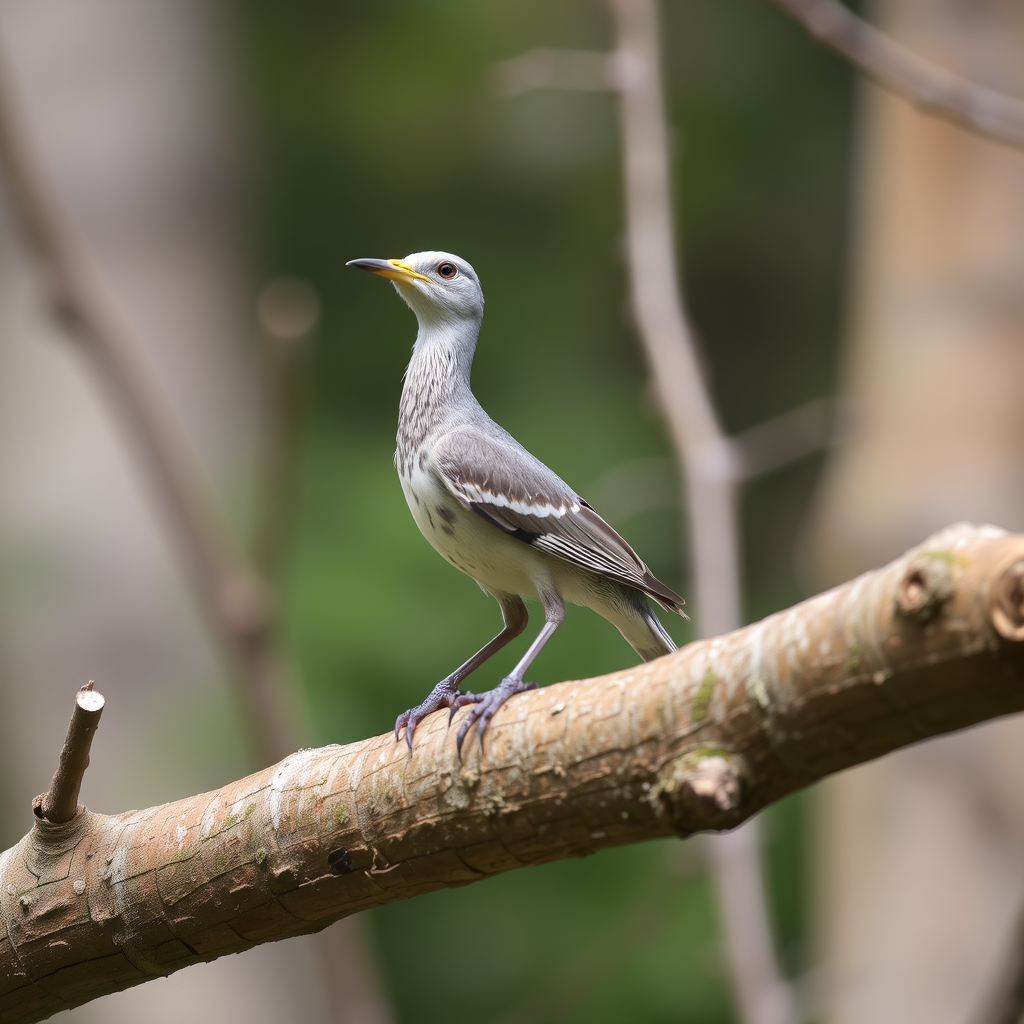

In [9]:
# warmup
gen_img("cat")
gen_img("dog")
gen_img("bird")

# For information only - Code used to quantize the model

### Performance tests on RTX A6000 Ada 48GB with Pytorch 2.4 and torchao 0.5.0

#### Full pipeline

Memory after loading the model / Memory during generation at batch size 1 - Generation time

- bf16 : 32 630 / 37 360 MB - 2.5 sec
- int8 : 17 270 / 21 410 MB - 3.1 sec
- int4 :  9 950 / 13 780 MB - 11.5 sec

The pipeline executes the 4 models below, here is the memory necessary to load each model:

#### Text Encoder 1

- bf16 :   700 MB
- int8 : 1 020 MB
- int4 :   810 MB

#### Text Encoder 2

- bf16 : 9 520 MB
- int8 : 5 640 MB
- int4 : 3 620 MB

#### Diffusion Transformer

- bf16 : 23 130 MB
- int8 : 12 200 MB
- int4 :  7 400 MB

#### VAE

- bf16 : 600 MB
- int8 : 670 MB
- int4 : 670 MB

### Quantize the 2 biggest models to 8 bits

In [1]:
from pathlib import Path
from diffusers import DiffusionPipeline, FluxTransformer2DModel, AutoencoderKL
from transformers import T5EncoderModel, CLIPTextModel
from torchao.quantization import quantize_, int8_weight_only, int4_weight_only
import torch 

original_repo = "black-forest-labs/FLUX.1-schnell"

quant_precision = int8_weight_only()
local_model_dir = Path("FLUX.1-schnell-torchao-int8")

# FAILED to reload the transformer in 4 bits on RTX 3070: TensorCoreTiledAQTLayout not supported on CPU,
# because the model is too big to be put on the GPU in bf16 (what the code believes the weights are)
# quant_precision = int4_weight_only(use_hqq=True)
# local_model_dir = Path("FLUX.1-schnell-torchao-int4")

In [ ]:
# Quantize text encoder 2
text_encoder_2 = T5EncoderModel.from_pretrained(
    original_repo, subfolder="text_encoder_2", torch_dtype=torch.bfloat16
)

quantize_(text_encoder_2, quant_precision, device="cuda")
text_encoder_2.save_pretrained(local_model_dir/"text_encoder_2", safe_serialization=False)

In [ ]:
# Quantize diffusion Transformer
transformer = FluxTransformer2DModel.from_pretrained(
    original_repo, subfolder="transformer", torch_dtype=torch.bfloat16
)

quantize_(transformer, quant_precision, device="cuda")
transformer.save_pretrained(model_dir/"transformer", safe_serialization=False)

Now the files are avaiable in the local directory.

Upload them to the target Huggingface repository.